# Tutorial: Comparison of Concrete ML Regressors

In this tutorial, we will compare the performance of different **Concrete ML** regressors with scikit-learn regressors. Concrete ML regressors have an API that is very similar to scikit-learn regressors, with two additional elements:

* compiling the model to FHE
* predicting in FHE

To test Fully Homomorphic Encryption (FHE) regressors, we can use a simulated FHE environment that is much faster than running in FHE. Although it does not operate over encrypted data, it is useful to design and train FHE-compatible regressors, as it allows the user to investigate whether the FHE constraints are met at design time.

### FHE runtime considerations and simulation

Here, a single test data is executed in FHE to get the execution time and the decision function values for the domain grid are computed using an FHE simulation. Thus:

* the R2 score reported is computed in simulated mode

This notebook is the regressor version of the following tutorial : [Tutorial: Comparison of Concrete ML Classifier](https://github.com/zama-ai/concrete-ml)

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from concrete.ml.sklearn import (
    DecisionTreeRegressor,
    LinearRegression,
    LinearSVR,
    NeuralNetRegressor,
    RandomForestRegressor,
    XGBRegressor,
)

%matplotlib inline

rng = np.random.RandomState(42)

In [2]:
def make_regression_data(
    n_samples=200,
    n_features=1,
    bias=0.0,
    noise_scale=1.0,
    loc=0.0,
    scale=1.0,
    polynomial_exp=1,
    target_scale=1.0,
    feature_scale=1.0,
):
    """
    Generates a dataset for regression models.
    """
    X = rng.randn(n_samples, n_features)
    # To avoid to have to big numbers on polynomial datasets
    if polynomial_exp > 1:
        feature_scale = 1
    X = feature_scale * np.sort(X, 0)
    scale = scale * polynomial_exp
    noise = noise_scale * rng.normal(loc=loc, scale=scale, size=n_samples)
    y = X.ravel() ** polynomial_exp + bias + noise
    y *= target_scale
    return X, y

### Prerequisites
Before diving deep into the topic, it's important to review some prerequisites.

Quantization is a technique that discretizes continuous data, such as floating point numbers, into a fixed range of integers. This process may result in some loss of information, but a larger integer range can reduce error, making it acceptable in some cases.

To learn more about quantization, you can refer to this [page](https://docs.zama.ai/concrete-ml/advanced-topics/quantization).

In the context of FHE, input data must be represented exclusively as integers, requiring the use of quantization. As a result:
* For linear models, quantization is performed after training by finding the best integer weight representations based on input and weight distribution. Users can manually set the n_bits parameter. Linear FHE models can handle large integers up to 50 bits, enabling the quantization of inputs and weights over many bits (e.g., 16) while handling data-sets with many features (e.g., 1000). Thus, they typically exhibit minimal loss, resulting in similar performance scores (e.g., R2 score) to float and quantized models.

* For tree-based models, both training and test data are quantized. A maximum accumulator bit-width of n+1 bits is needed for models trained with n_bits=n. A value of 5 or 6 bits gives the same accuracy as training in floating point, while values above 7 do not increase model performance and cause slowdowns.

* Built-in neural networks use several linear layers and Quantization Aware Training. The maximum accumulator bit-width is controlled by the number of weights and activation bits, as well as a pruning factor. This factor is automatically determined based on the desired accumulator bit-width and a multiplier factor can be optionally specified.

To learn more about the relationship between the maximum bit-width reached within a model, the bits of quantization used, and the number of features in the data-set, please refer to this [page](https://docs.preprod.zama.ai/concrete-ml/main/advanced-topics/pruning.html?highlight=formula#pruning-in-practice).

### Regression model with Concrete ML

The development flow for a Concrete ML Regressions model includes the following steps:

- The model is trained on plaintext data, as only FHE inference is supported.

- Depending on the model type, quantization is performed with the associated scheme. The available quantization schemes can be found at the bottom of the notebook.

- The quantized model is compiled into an FHE equivalent using three steps: creating an executable operation graph, checking that the graph is FHE-compatible by verifying the maximum bit-width required for executing the model, and determining the cryptographic parameters to generate the secret and evaluation keys. If the compilation process fails due to the lack of parameters, the user can lower the value of n_bits for linear models or decrease the number of features in the data-set (using techniques such as PCA) and repeat the development flow.

- Inference can be performed on encrypted data.

In [3]:
# pylint: disable=too-many-locals,too-many-statements


def make_regressor_comparison(title, regressors, **kwargs):
    print(title)

    # Create subplots where each column represents a polynomial degree
    subplot_col = kwargs.get("polynomial_exp", 1)
    fig, axs = plt.subplots(len(regressors), subplot_col, figsize=(15, 8), sharex=False)

    # Create data-sets for each polynomial degree
    for i in range(subplot_col):
        kwargs_copy = kwargs.copy()
        kwargs_copy["polynomial_exp"] = i + 1
        X, y = make_regression_data(**kwargs_copy)

        # Split the data into training and test sets
        # Use 15 percent (30 points for a data-set of 200 points) for prediction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        sort_test_index = np.argsort(X_test.ravel())
        X_test = X_test[sort_test_index, :]
        y_test = y_test[sort_test_index]

        # Feature preprocessing
        # Linear models require polynomial features to be applied before training
        # to fit a non-linear model and other models perform better with this transoformation
        pipe = Pipeline(
            [
                ("poly", PolynomialFeatures(i + 1)),
                ("scaler", StandardScaler()),
            ]
        )

        X_poly_train = pipe.fit_transform(X_train)
        X_poly_test = pipe.transform(X_test)

        # Iterate over the given regressors
        for j, (regressor, model_name) in enumerate(regressors):
            print(f"Evaluation of {model_name}")
            if np.ndim(axs) > 1:
                axs[0, i].set_title(f"Polynomial degree {i + 1}")
                ax = axs[j, i]
            else:
                try:
                    axs[i].set_title(f"Polynomial degree {i + 1}")
                    ax = axs[i]
                except IndexError:
                    ax = axs
                    ax.set_title(f"Polynomial degree {i + 1}")

            # Plot the training points
            ax.scatter(
                X_train,
                y_train,
                edgecolors="k",
                label="Train data",
            )

            # Plot the testing points
            ax.scatter(
                X_test,
                y_test,
                marker="D",
                alpha=0.6,
                edgecolors="k",
                label="Test data",
            )

            # Instantiate the model
            model = regressor()

            # Train the model and retrieve both the Concrete-ML model and its equivalent one from
            # scikit-learn
            # If the model is a NeuralNetClassifier, instantiate a scikit-learn MLPClassifier
            # separately in order to be able to be able to compare the results with a float model
            # that doesn't use QAT
            if model.__class__ == NeuralNetRegressor:

                sklearn_model = MLPRegressor(
                    alpha=1,
                    activation="identity",
                    max_iter=1000,
                    hidden_layer_sizes=(25,),
                    learning_rate_init=0.005,
                )
                sklearn_model.fit(X_poly_train, y_train)

                # When we apply PolynomialFeatures the input dim is equal to degree of polynome + 1
                model.module__input_dim = i + 2
                concrete_model = model.fit(X_poly_train, y_train.reshape(-1, 1))

            else:

                concrete_model, sklearn_model = model.fit_benchmark(X_poly_train, y_train)

            # Compute the predictions in clear using the scikit-learn model
            sklearn_y_pred = sklearn_model.predict(X_poly_test)

            # Compile the Contrete-ML model
            circuit = concrete_model.compile(X_poly_train)

            print(
                "Generating a key for a " f"{circuit.graph.maximum_integer_bit_width()}-bit circuit"
            )

            time_begin = time.time()
            circuit.client.keygen(force=False)
            time_end = time.time()
            print(f"Key generation time: {time_end - time_begin:.2f} seconds")

            # Compute the predictions in FHE using the Concrete-ML model
            time_begin = time.time()
            concrete_y_pred = concrete_model.predict(X_poly_test[:1], fhe="execute")
            time_end = time.time()

            print(f"Execution time: {(time_end - time_begin):.2f} " "seconds per sample in FHE")

            # Compute predictions for all test examples with the simulate mode
            concrete_y_pred = concrete_model.predict(X_poly_test, fhe="simulate")

            # Measure the R2 score
            sklearn_score = r2_score(sklearn_y_pred, y_test)
            concrete_score = r2_score(concrete_y_pred, y_test)

            is_a_tree_based_model = concrete_model.__class__ in [
                DecisionTreeRegressor,
                RandomForestRegressor,
                XGBRegressor,
            ]

            # If the model is not a tree-based model, retrieve the maximum integer bitwidth
            # reached within its circuit.
            bitwidth = None
            if not is_a_tree_based_model:
                bitwidth = circuit.graph.maximum_integer_bit_width()

            # Plot the predictions
            ax.plot(X_test, concrete_y_pred, c="blue", linewidth=2.5, label="Concrete-ML")

            # Plot the predictions
            ax.plot(X_test, sklearn_y_pred, c="red", linewidth=2.5, label="scikit-learn")

            ax.text(
                0.5,
                0.80,
                f"Concrete-ML R2: {concrete_score:.2f}\n scikit-learn R2: {sklearn_score:.2f}\n",
                transform=ax.transAxes,
                fontsize=12,
                va="top",
                ha="right",
            )
            if bitwidth:
                ax.text(
                    0.75,
                    0.1,
                    f"bitwidth={bitwidth}",
                    transform=ax.transAxes,
                    fontsize=12,
                    va="bottom",
                    ha="left",
                )
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc="upper left")

            scaler = 0.5
            if len(regressors) == 3:
                scaler = 0.3
            fig.text(
                -0.05, 0.75 - j * scaler, f"{model_name}", ha="center", va="bottom", fontsize=14
            )

    plt.tight_layout(pad=1.2)
    plt.show()

#### Neural net-based regressor.

NN Regressors
Evaluation of Neural Net


Generating a key for a 14-bit circuit
Key generation time: 1.19 seconds
Execution time: 15.25 seconds per sample in FHE


Evaluation of Neural Net


Generating a key for a 12-bit circuit
Key generation time: 1.16 seconds


Execution time: 17.13 seconds per sample in FHE


Evaluation of Neural Net


Generating a key for a 14-bit circuit
Key generation time: 1.17 seconds


Execution time: 16.51 seconds per sample in FHE


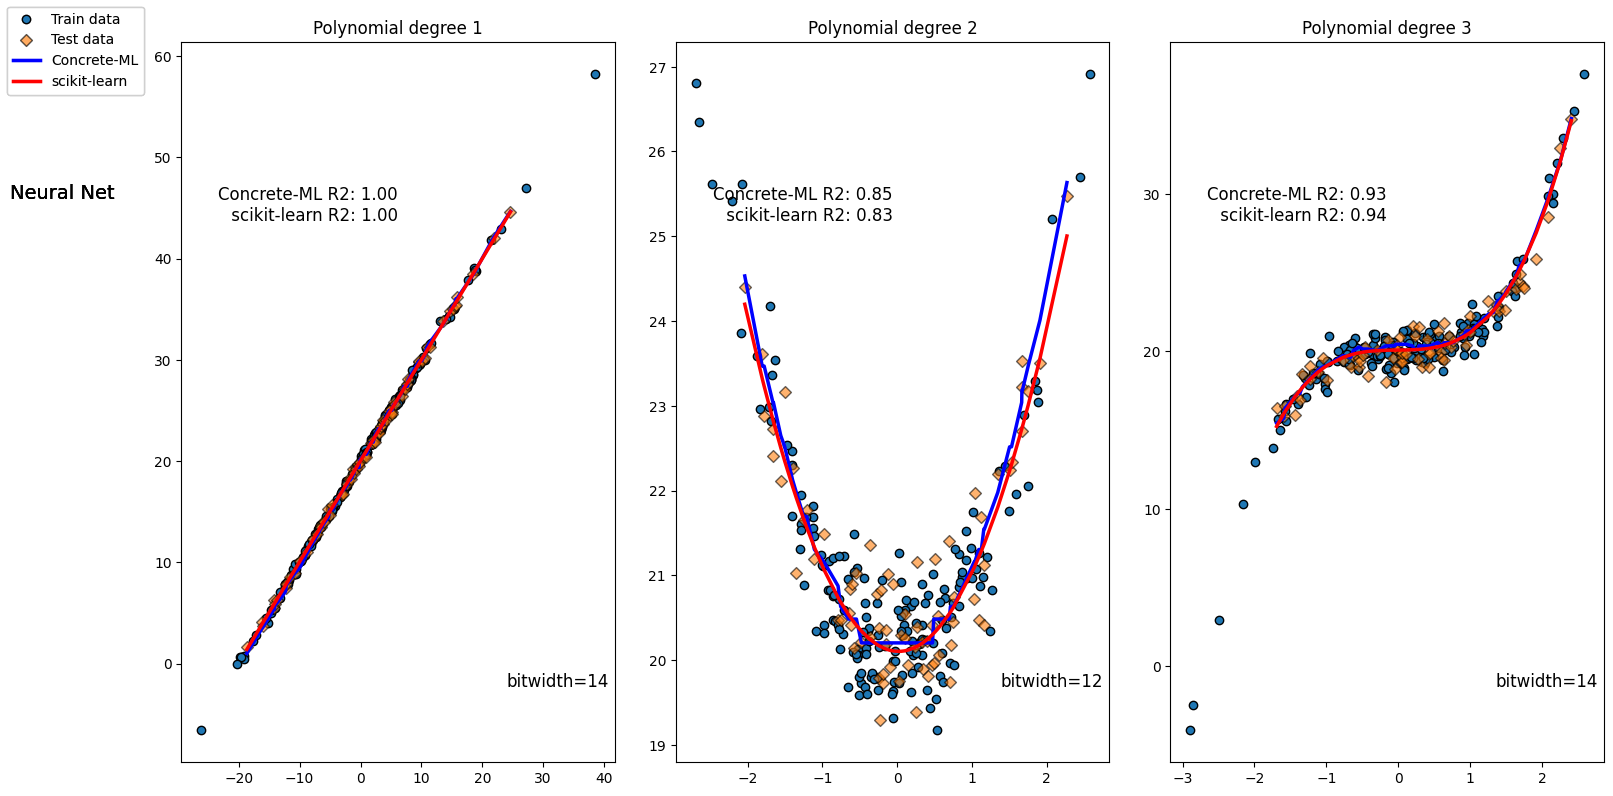

In [4]:
params_neural_net = {
    "module__n_w_bits": 6,
    "module__n_a_bits": 8,
    "module__n_accum_bits": 16,
    "module__n_hidden_neurons_multiplier": 10,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.Identity,
    "max_epochs": 400,
    "verbose": 0,
    "lr": 0.1,
}


neural_network_regressor = [
    (
        partial(NeuralNetRegressor, batch_size=32, **params_neural_net),
        "Neural Net",
    ),
]
make_regressor_comparison(
    "NN Regressors",
    neural_network_regressor,
    n_samples=250,
    polynomial_exp=3,
    bias=20,
    scale=0.25,
    target_scale=1,
    feature_scale=10,
)

#### Linear regressor.

linear
Evaluation of Linear SVR


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE
Evaluation of Linear Regression


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE
Evaluation of Linear SVR


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE
Evaluation of Linear Regression


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE
Evaluation of Linear SVR


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE
Evaluation of Linear Regression


Generating a key for a 8-bit circuit
Key generation time: 0.00 seconds
Execution time: 0.00 seconds per sample in FHE


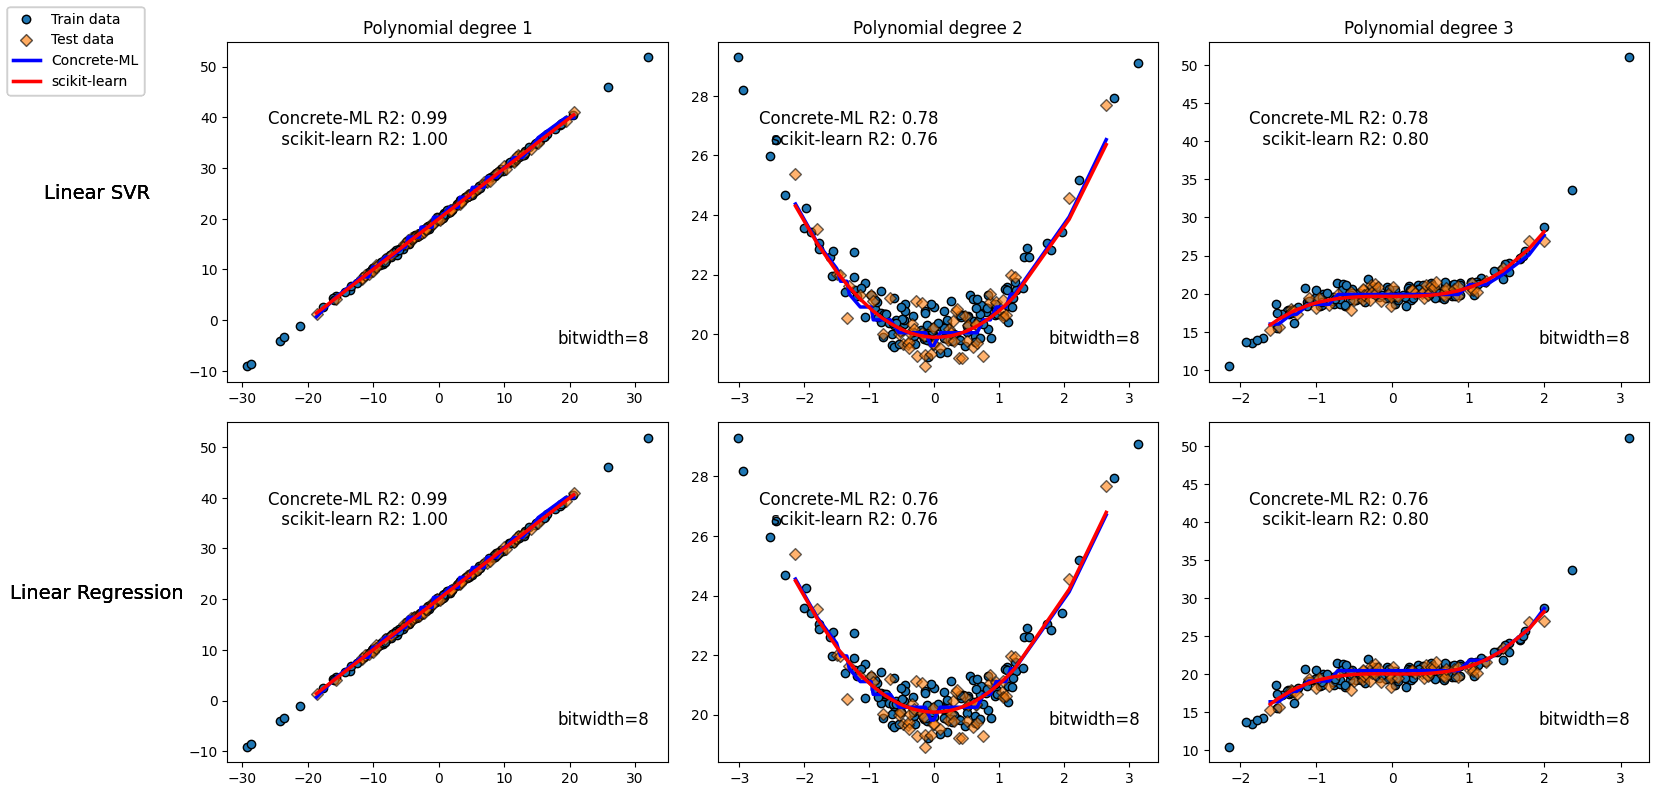

In [5]:
np.random.seed(42)
linear_regressor = [
    (partial(LinearSVR, n_bits={"op_inputs": 5, "op_weights": 2}, C=0.5), "Linear SVR"),
    (partial(LinearRegression, n_bits={"op_inputs": 5, "op_weights": 2}), "Linear Regression"),
]
make_regressor_comparison(
    "linear",
    linear_regressor,
    polynomial_exp=3,
    bias=20,
    scale=0.25,
    target_scale=1,
    feature_scale=10,
)

### Tree and tree ensemble classifiers

Tree-Based Regressors


Evaluation of Decision Tree


Generating a key for a 7-bit circuit
Key generation time: 0.51 seconds
Execution time: 0.67 seconds per sample in FHE


Evaluation of RandomForestRegressor


Generating a key for a 7-bit circuit
Key generation time: 0.45 seconds


Execution time: 0.70 seconds per sample in FHE


Evaluation of XGB


Generating a key for a 8-bit circuit
Key generation time: 0.45 seconds


Execution time: 0.67 seconds per sample in FHE


Evaluation of Decision Tree


Generating a key for a 7-bit circuit
Key generation time: 0.50 seconds


Execution time: 0.32 seconds per sample in FHE


Evaluation of RandomForestRegressor


Generating a key for a 7-bit circuit
Key generation time: 0.44 seconds


Execution time: 0.65 seconds per sample in FHE


Evaluation of XGB


Generating a key for a 8-bit circuit
Key generation time: 0.44 seconds


Execution time: 0.88 seconds per sample in FHE


Evaluation of Decision Tree


Generating a key for a 7-bit circuit
Key generation time: 0.42 seconds


Execution time: 0.34 seconds per sample in FHE


Evaluation of RandomForestRegressor


Generating a key for a 7-bit circuit
Key generation time: 0.42 seconds


Execution time: 0.46 seconds per sample in FHE


Evaluation of XGB


Generating a key for a 8-bit circuit
Key generation time: 0.45 seconds


Execution time: 0.76 seconds per sample in FHE


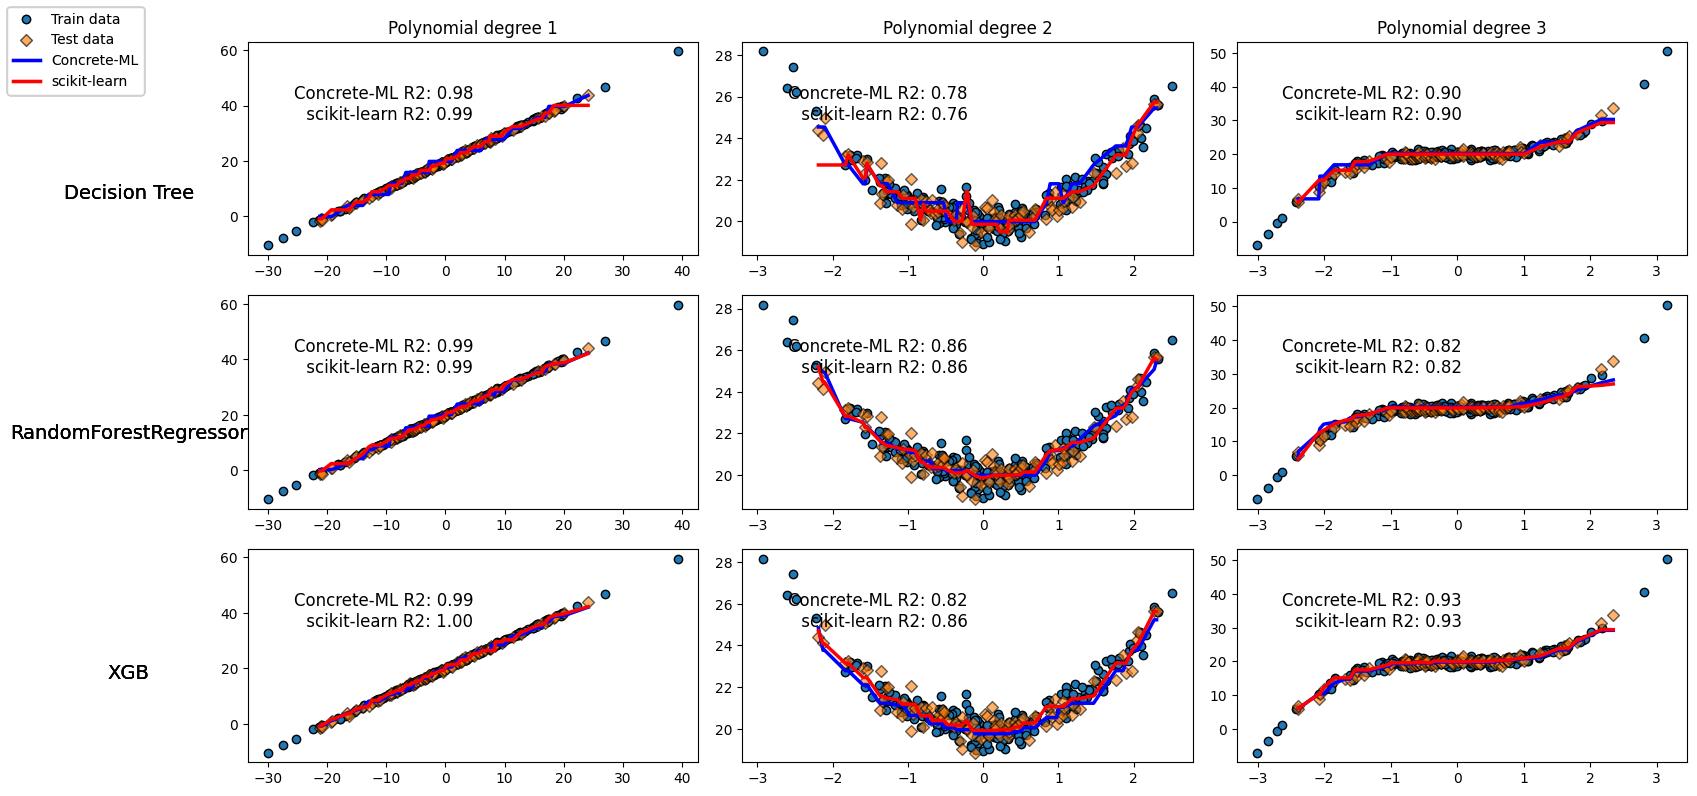

In [6]:
tree_regressors = [
    (partial(DecisionTreeRegressor, n_bits=5, max_depth=5), "Decision Tree"),
    (partial(RandomForestRegressor, n_bits=5), "RandomForestRegressor"),
    (
        partial(XGBRegressor, n_bits=6, n_estimators=50, max_depth=3, gamma=1, learning_rate=0.3),
        "XGB",
    ),
]

make_regressor_comparison(
    "Tree-Based Regressors",
    tree_regressors,
    n_samples=300,
    polynomial_exp=3,
    bias=20,
    scale=0.25,
    target_scale=1,
    feature_scale=10,
)

# Conclusion:

We compared the performance of different linear regression models using Concrete ML and scikit-learn libraries in Python. The purpose of this tutorial was to show the effectiveness of linear regression models in Fully Homomorphic Encryption (FHE) and to provide a comparison between the different models.

We evaluated three types of linear regression models using an R2 score: 
* linear (Support Vector Regressor, Linear Regression)
* neural networks (multi-layer non-linear models)
* tree-based (Decision Tree, Random Forest, XGBoost)

The R2 score of the Concrete regressors is measured on encrypted data. These regressors work with parameters and inputs that are heavily quantized and, thus, show R2 score loss (especially in XBGRegressor):

* linear regression models: linear regression models in FHE have good performance and are fast. These models are accurate as they require very little quantization. Their performance is almost identical to that of their fp32 counterparts.

* tree-based regression models: Tree-based regression models achieve a good R2 score on encrypted data in both fp32 and quantized mode in FHE, thanks to their unique computations. In fact, using a Random Forest model on a polynomial of degree 3 can even improve their performance further. However, XGBRegressor is an exception as its performance is not as good in quantized mode compared to fp32. This is because the best parameters for XGBRegressor were identified for fp32 models and were applied to the quantized version, resulting in a lower R2 score.

* neural network regressors: as seen above, neural network regressors have good performance in FHE despite being subjected to heavy quantization thanks to Quantization Aware Training (QAT) techniques.

One way to reduce the performance gap between FHE and their fp32 counterparts for complex models like neural networks or XGBRegressor, which require more hyperparameter optimization work, is to use the GridSearch method separately on both FHE and fp32 models. This is recommended instead of using the ".fit_benchmark" method, which forces the use of the same hyperparameters on both models. For an example using GridSearch in the context of Concrete ML, please refer to this (page)[https://github.com/zama-ai/concrete-ml/blob/release/0.6.x/docs/advanced_examples/LinearRegression.ipynb]

It should be noted that the number of samples is relatively low for runtime purposes, especially for tree-based models and neural networks, where feature engineering was not performed.

Refer to [Classifier version of this notebook](https://github.com/zama-ai/concrete-ml)